In [14]:
import json
import os

with open('/home/fassty/Devel/school/diploma_thesis/code/exp_results/baseline_experiment/DQN/DQN_1M_iterations_1day/DQN_StockExchangeEnv-v0_bc710_00000_0_2023-05-25_12-41-47/result.json', 'r') as f:
    eval_results = []
    for line in f:
        data = json.loads(line)
        if 'evaluation' in data:
            eval_results.append(data['evaluation'])

    last_result = eval_results[-1]

{'episode_reward_max': 699.183022417832, 'episode_reward_min': 553.675505793497, 'episode_reward_mean': 582.777009118364, 'episode_len_mean': 1440.0, 'episode_media': {}, 'episodes_this_iter': 20, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [699.183022417832, 699.183022417832, 699.183022417832, 699.183022417832, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497, 553.675505793497], 'episode_lengths': [1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 2.01261143218027, 'mean_inference_ms': 1.9704394564225027, 'mean_action_processing_ms': 0.4881262160027009, 'mean_env_wai

In [67]:
import re
import pandas as pd

root_dir = '../exp_results/baseline_experiment'

def load_eval_results(path):
    eval_results = []
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            if 'evaluation' in data:
                eval_results.append(data['evaluation'])

    if len(eval_results) == 0:
        print(path)
    return eval_results[-1]

results = []
for alg_name in os.listdir(root_dir):
    for result_dir in os.listdir(os.path.join(root_dir, alg_name)):
        if not 'day' in result_dir:
            continue

        n_days = int(re.findall('([0-9]+)day', result_dir)[0])

        for root, _, files in os.walk(os.path.join(root_dir, alg_name, result_dir)):
            if 'result.json' in files:
                eval_result = load_eval_results(os.path.join(root, 'result.json'))
                results.append((alg_name, n_days, eval_result['episode_reward_mean'], eval_result['episode_reward_min'], eval_result['episode_reward_max']))

df = pd.DataFrame(results, columns=['alg_name', 'n_days', 'reward_mean','reward_min','reward_max'])
df = df.sort_values(by=['alg_name', 'n_days'], ascending=[True, True])
df

,alg_name,n_days,reward_mean,reward_min,reward_max
75,DQN,1,582.777009,553.675506,699.183022
76,DQN,1,990.843322,809.547805,1036.167201
77,DQN,1,715.127045,571.190618,751.111152
60,DQN,2,398.785524,141.358511,714.543865
61,DQN,2,428.268820,129.046794,626.744345
...,...,...,...,...,...
52,SAC,180,360.399046,41.778119,1738.011822
53,SAC,180,370.456737,5.963596,937.712888
48,SAC,365,239.681635,-147.847882,1054.192941
49,SAC,365,390.286880,19.592960,960.495111


In [50]:
import numpy as np

from rl_trading.simulation.env import StockExchangeEnv0
from rl_trading.data.indicators import *

state_config = {
        'market_state': ['vwap'],
        'technical_indicators': [
            (EMA, dict(timeperiod=5, normalize=True), '1min'),
            (EMA, dict(timeperiod=13, normalize=True), '1min'),
            (RSI, dict(timeperiod=7, normalize=True), '1min'),
            (BBANDS, dict(timeperiod=10), '1min'),
            (EMA, dict(timeperiod=20, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1h'),
            (RSI, dict(timeperiod=14, normalize=True), '1h'),
            (BBANDS, dict(timeperiod=20), '1h'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1d'),
            (EMA, dict(timeperiod=200, normalize=True), '1d'),
            (RSI, dict(timeperiod=14, normalize=True), '1d'),
            (BBANDS, dict(timeperiod=20), '1d'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1d'),
        ]}

optimal_rewards = {}
for n_days in [1, 2, 3, 7, 14, 30, 90, 180, 365]:
    idxs = np.linspace(288000, 2792281 - 1440 - 1, n_days, dtype=int)
    rewards = []
    for idx in idxs:
        env = StockExchangeEnv0(state_config=state_config, _idxs_range=[idx])

        env.reset()
        done = False
        reward_total = 0
        while not done:
            current_idx = env.current_idx
            current_price = env.price_data['1min'][current_idx]
            next_price = env.price_data['1min'][current_idx + 1]
            if next_price > current_price:
                action = 1
            elif next_price < current_price:
                action = 2
            else:
                action = 0
            state, reward, done, _, _ = env.step(action)
            reward_total += reward
        rewards.append(reward_total)
    print(f'Rewards for {n_days} days: {np.mean(rewards)}')
    optimal_rewards[n_days] = np.mean(rewards)

print(optimal_rewards)

Rewards for 1 days: 3524.0318073657327
Rewards for 2 days: 2448.108463408131
Rewards for 3 days: 2196.5172885797583
Rewards for 7 days: 4578.045584805158
Rewards for 14 days: 5281.126865380163
Rewards for 30 days: 5046.436411228319
Rewards for 90 days: 5209.73555386386
Rewards for 180 days: 5561.167910107364
Rewards for 365 days: 4924.183543495301
{1: 3524.0318073657327, 2: 2448.108463408131, 3: 2196.5172885797583, 7: 4578.045584805158, 14: 5281.126865380163, 30: 5046.436411228319, 90: 5209.73555386386, 180: 5561.167910107364, 365: 4924.183543495301}


In [68]:
for n_days, return_ in optimal_rewards.items():
    df.loc[df['n_days'] == n_days,['reward_mean','reward_min','reward_max']] = df[df['n_days'] == n_days][['reward_mean','reward_min','reward_max']] / return_ * 100

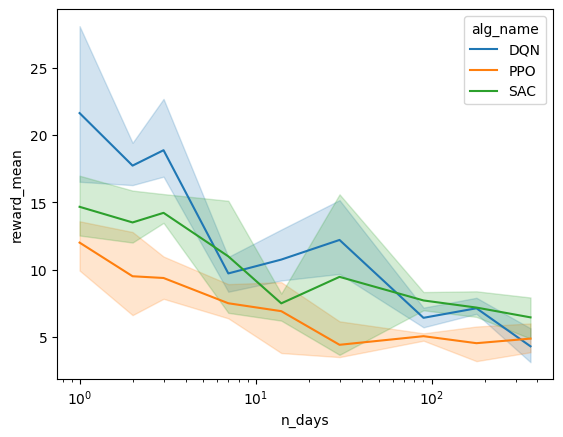

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x='n_days', y='reward_mean', hue='alg_name', data=df)
plt.xscale('log')

In [73]:
np.geomspace(1, 1000, 10)

array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])